# Modeling Notebook

## Libary Imports

In [ ]:
## Import necessary libraries here
import os
import random
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from pathlib import Path
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.utils.class_weight import compute_class_weight
from matplotlib.ticker import ScalarFormatter

warnings.filterwarnings("ignore")

In [2]:
# set the random seed for reproducibility
RANDOM_SEED = 2025

# Establish output directories for images and tables developed
IMAGE_DIR = Path("../Images/")
TABLE_DIR = Path("../Tables/")

In [3]:
# create helper functions to save images and tables to respective directories
def save_figure(fig, filename: str, dpi: int = 300) -> None:
    """
    Save a matplotlib/seaborn figure to the Images directory.
    """
    filepath = IMAGE_DIR / filename
    fig.savefig(filepath, dpi=dpi, bbox_inches="tight")
    print(f"Saved figure to {filepath}")

def save_table(df, filename: str, index: bool = False) -> None:
    """
    Save a pandas or polars DataFrame to the Tables directory as CSV.
    """
    filepath = TABLE_DIR / filename

    # Handle polars vs pandas
    if isinstance(df, pl.DataFrame):
        df.write_csv(str(filepath))
    else:
        # assume pandas-like
        df.to_csv(str(filepath), index=index)

    print(f"Saved table to {filepath}")

## Data Access and Loading

In [4]:
# set the filepath to the parquet cleaned dataset
PATH = "../Data/Cleaned/Cleaned_Dataset.parquet"

# scan the parquet file with polars
scan = pl.scan_parquet(PATH)

df = scan.collect()
# drop the unneeded target columns for this 8-family analysis
df = df.drop(['Label', 'Label_Binary'])

# get schema
schema = df.schema

# cast Protocol_Type to categorical
df = df.with_columns(pl.col("Protocol_Type").cast(pl.Categorical))


In [5]:
# set feature and target variables
TARGET_FAMILY = 'Label_Family'

feature_columns = [col for col in df.columns if col != TARGET_FAMILY]

# categorical columns
CATEGORICAL_COLUMNS = ["Protocol_Type"]
# numerical columns
NUMERICAL_COLUMNS = [col for col, dtype in schema.items() if dtype in [pl.Int32, pl.Float32] and col != TARGET_FAMILY]

In [6]:
# convert to pandas for modeling
pdf = df.to_pandas()

X = pdf[feature_columns]
y = pdf[TARGET_FAMILY]

# Train / Test / Validation Split

In order to properly handle the imbalanced nature of the dataset the training data will be split and have a balanced nature to capture the minority class better. The test and validation sets will remain imbalanced to reflect real world data and to properly evaluate model performance.

In [7]:
# stratified split into train_full and temp (val+test)
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,          # 70% train, 30% temp (val+test)
    stratify=y,
    random_state=RANDOM_SEED
)

# split temp into validation and test (both still imbalanced but representative)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,          # 15% val, 15% test overall
    stratify=y_temp,
    random_state=RANDOM_SEED
)

print("Class distribution (train_full):")
print(y_train_full.value_counts(normalize=True))

print("\nClass distribution (val):")
print(y_val.value_counts(normalize=True))

print("\nClass distribution (test):")
print(y_test.value_counts(normalize=True))

Class distribution (train_full):
Label_Family
DDOS           0.585191
DOS            0.198946
MIRAI          0.112314
BENIGN         0.049859
RECON          0.031205
SPOOFING       0.020760
WEB            0.001129
BRUTE_FORCE    0.000596
Name: proportion, dtype: float64

Class distribution (val):
Label_Family
DDOS           0.585191
DOS            0.198947
MIRAI          0.112314
BENIGN         0.049859
RECON          0.031205
SPOOFING       0.020760
WEB            0.001129
BRUTE_FORCE    0.000596
Name: proportion, dtype: float64

Class distribution (test):
Label_Family
DDOS           0.585191
DOS            0.198947
MIRAI          0.112314
BENIGN         0.049859
RECON          0.031205
SPOOFING       0.020760
WEB            0.001129
BRUTE_FORCE    0.000596
Name: proportion, dtype: float64


In [8]:
# building the balanced training set via undersampling majority classes

# combine X_train_full and y_train_full for easier group-wise sampling
train_full_df = X_train_full.copy()
train_full_df[TARGET_FAMILY] = y_train_full.values

# Count examples per class
class_counts = train_full_df[TARGET_FAMILY].value_counts()
print("\nTraining class counts (before balancing):")
print(class_counts)

# Smallest class size (wundersample all classes down to this)
min_count = class_counts.min()
print(f"\nUsing min_count = {min_count} samples per class for balanced training.")

balanced_parts = []

for label, count in class_counts.items():
    class_subset = train_full_df[train_full_df[TARGET_FAMILY] == label]
    
    # Sample without replacement down to min_count for majority classes,
    # keep all samples for classes already at min_count
    if count > min_count:
        sampled = class_subset.sample(
            n=min_count,
            random_state=RANDOM_SEED
        )
    else:
        sampled = class_subset
    
    balanced_parts.append(sampled)

# Concatenate and shuffle to create the final balanced training set
train_balanced_df = (
    pd.concat(balanced_parts, axis=0)
      .sample(frac=1.0, random_state=RANDOM_SEED)  # shuffle
      .reset_index(drop=True)
)

# Separate features and target for the balanced training data
X_train_bal = train_balanced_df.drop(columns=[TARGET_FAMILY])
y_train_bal = train_balanced_df[TARGET_FAMILY]

print("\nTraining class counts (after balancing):")
print(y_train_bal.value_counts())


Training class counts (before balancing):
Label_Family
DDOS           8604454
DOS            2925243
MIRAI          1651428
BENIGN          733116
RECON           458825
SPOOFING        305243
WEB              16595
BRUTE_FORCE       8764
Name: count, dtype: int64

Using min_count = 8764 samples per class for balanced training.

Training class counts (after balancing):
Label_Family
DDOS           8764
MIRAI          8764
SPOOFING       8764
BRUTE_FORCE    8764
WEB            8764
DOS            8764
RECON          8764
BENIGN         8764
Name: count, dtype: int64


In [9]:
# Encode target labels
label_encoder = LabelEncoder()
y_train_bal_enc = label_encoder.fit_transform(y_train_bal)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

class_names = label_encoder.classes_
n_classes = len(class_names)

## LightGBM Model

In [10]:
# Preprocessing: ColumnTransformer for numeric + categorical
# Numeric: passthrough (trees/boosting don't need scaling)
# Categorical: OneHotEncode Protocol_Type
numeric_features = NUMERICAL_COLUMNS
categorical_features = CATEGORICAL_COLUMNS

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Define the LightGBM classifier
lgbm_clf = LGBMClassifier(
    objective="multiclass",
    random_state=RANDOM_SEED,
    n_estimators=200,
    learning_rate=0.1,
    n_jobs=-1
)

# Build the full modeling pipeline
lgbm_pipeline = SKPipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", lgbm_clf),
    ]
)

# Cross-validation on the balanced training data
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_SEED
)

cv_results = cross_validate(
    lgbm_pipeline,
    X_train_bal,
    y_train_bal_enc,
    cv=cv,
    scoring=[
        "accuracy",
        "f1_macro", "f1_weighted",
        "precision_macro", "precision_weighted",
        "recall_macro", "recall_weighted",
    ],
    n_jobs=-1,
    return_train_score=False
)

cv_df = pd.DataFrame(cv_results)
cv_summary = cv_df[
    [
        "test_accuracy",
        "test_f1_macro", "test_f1_weighted",
        "test_precision_macro", "test_precision_weighted",
        "test_recall_macro", "test_recall_weighted",
    ]
].agg(["mean", "std"]).T

cv_summary.columns = ["mean", "std"]
print("\nCross-validation performance (balanced training set):")
print(cv_summary)

# Save CV results and summary
save_table(cv_df, "LightGBM_CV_Results.csv", index=False)
save_table(cv_summary, "LightGBM_CV_Summary.csv", index=True)

# fit the LightGBM pipeline on the full balanced training set
lgbm_pipeline.fit(X_train_bal, y_train_bal_enc)


Cross-validation performance (balanced training set):
                             mean       std
test_accuracy            0.757203  0.002224
test_f1_macro            0.757755  0.002040
test_f1_weighted         0.757754  0.002036
test_precision_macro     0.760958  0.002294
test_precision_weighted  0.760958  0.002290
test_recall_macro        0.757203  0.002229
test_recall_weighted     0.757203  0.002224
Saved table to ..\Tables\LightGBM_CV_Results.csv
Saved table to ..\Tables\LightGBM_CV_Summary.csv
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3916
[LightGBM] [Info] Number of data points in the train set: 70112, number of used features: 38
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score 

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



=== VAL SET PERFORMANCE ===
Accuracy            : 0.7798
Precision (macro)   : 0.6415
Precision (weighted): 0.8441
Recall (macro)      : 0.7581
Recall (weighted)   : 0.7798
F1 (macro)          : 0.6313
F1 (weighted)       : 0.7962

Classification Report (Val):
              precision    recall  f1-score   support

      BENIGN     0.8767    0.7518    0.8094    157096
 BRUTE_FORCE     0.0537    0.6651    0.0994      1878
        DDOS     0.9287    0.7285    0.8165   1843812
         DOS     0.5122    0.8360    0.6352    626838
       MIRAI     0.9948    0.9969    0.9958    353877
       RECON     0.7725    0.6111    0.6824     98320
    SPOOFING     0.9211    0.8449    0.8813     65409
         WEB     0.0727    0.6302    0.1303      3556

    accuracy                         0.7798   3150786
   macro avg     0.6415    0.7581    0.6313   3150786
weighted avg     0.8441    0.7798    0.7962   3150786



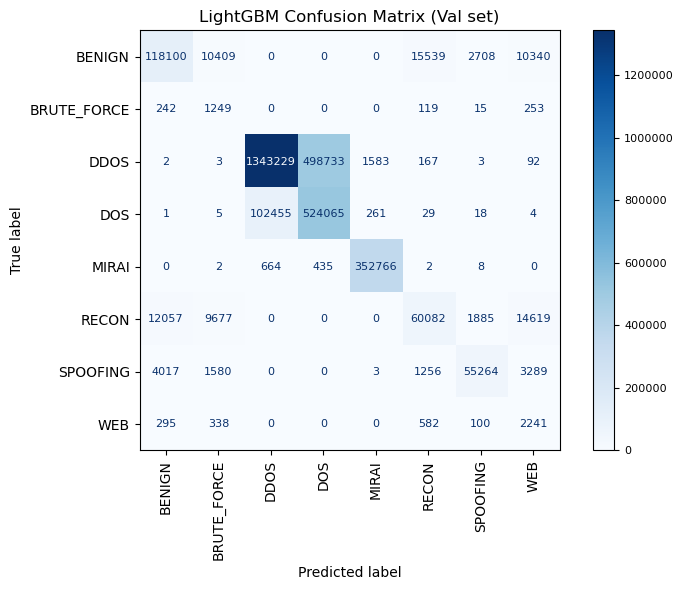


=== TEST SET PERFORMANCE ===
Accuracy            : 0.7798
Precision (macro)   : 0.6410
Precision (weighted): 0.8440
Recall (macro)      : 0.7573
Recall (weighted)   : 0.7798
F1 (macro)          : 0.6311
F1 (weighted)       : 0.7961

Classification Report (Test):
              precision    recall  f1-score   support

      BENIGN     0.8763    0.7506    0.8086    157096
 BRUTE_FORCE     0.0536    0.6592    0.0991      1878
        DDOS     0.9287    0.7286    0.8166   1843812
         DOS     0.5122    0.8360    0.6352    626838
       MIRAI     0.9947    0.9970    0.9959    353878
       RECON     0.7695    0.6100    0.6805     98319
    SPOOFING     0.9205    0.8470    0.8823     65409
         WEB     0.0727    0.6296    0.1303      3556

    accuracy                         0.7798   3150786
   macro avg     0.6410    0.7573    0.6311   3150786
weighted avg     0.8440    0.7798    0.7961   3150786



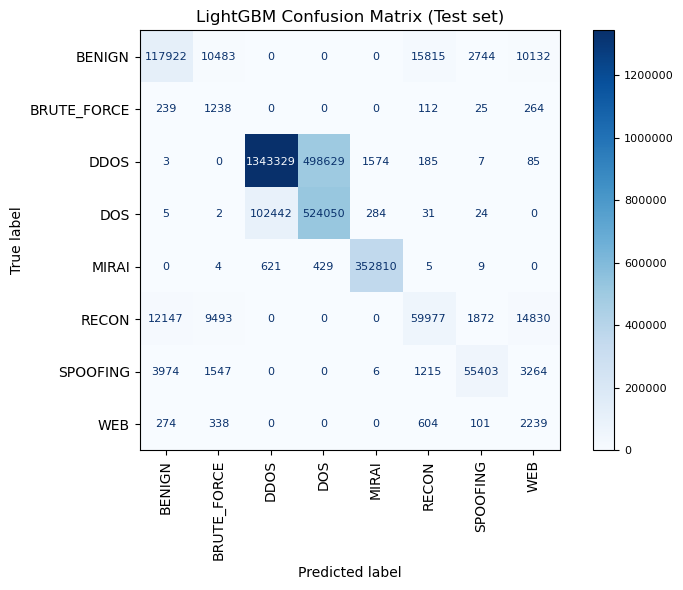

In [ ]:
# helper function for evaluation on val/test
def evaluate_multiclass_model(pipeline, X, y_true_enc, split_name="val"):
    """
    Evaluate a multiclass classifier with accuracy, precision, recall,
    macro/weighted F1, classification report, and confusion matrix (saved as image).
    """
    y_pred_enc = pipeline.predict(X)
    y_pred_proba = None
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nClassification Report ({split_name}):")
    print(report)

    # Save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    # save_table(report_df, f"LightGBM_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix (normalized by true labels)
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)
    # 1) Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)  # adjust to taste (e.g., 7, 9, etc.)
    # 2) Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(f"LightGBM Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    # save_figure(fig, f"LightGBM_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    # Return metrics in case we want to store them programmatically
    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }

# evaluate on validation and test sets (note: these are imbalanced and realistic)
val_results = evaluate_multiclass_model(
    lgbm_pipeline,
    X_val,
    y_val_enc,
    split_name="Val"
)

test_results = evaluate_multiclass_model(
    lgbm_pipeline,
    X_test,
    y_test_enc,
    split_name="Test"
)

## Random Forest Model

## CatBoost Model

## Adaboost Model

## XGBoost Model

## Logistic Regression Model

## Linear SVM Model

## CNN Model

# RNN Model

## LSTM Model